In [1]:
import os
os.chdir('/engram/nklab/hossein/recurrent_models/transformer_brain_encoder/')
!pwd

%matplotlib inline 
import matplotlib.pyplot as plt

import datasets
import pandas as pd
import numpy as np
import csv
import torch
import torchvision
from PIL import Image
import torch.nn as nn
from models.activations import get_transformer_activations
from collections import OrderedDict

from datasets.nsd_utils import roi_maps
from datasets.nsd import fetch_dataloaders

from sklearn.cluster import KMeans


/engram/nklab/hossein/recurrent_models/transformer_brain_encoder


In [2]:
data_dir = '../../../algonauts/algonauts_2023_challenge_data/'

class argObj:
     def __init__(self, data_dir, subj):

        self.subj = format(subj, '02')
        self.data_dir = os.path.join(data_dir, 'subj'+self.subj)


subj = 1
data_dir 
args = argObj(data_dir, subj)

args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args.readout_res = 'rois_all'

In [40]:
lh_challenge_rois

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 3, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([3, 0, 7, ..., 5, 5, 5])]

In [43]:
{0:'uknown', 1:'ul_1', 2:'ul_2', 3:'ul_3', 4:'ul_4', 5:'ul_5', 6:'ul_6', 7:'ul_7', 8:'ul_8', 9:'ul_9', 10:'ul_10'}

[{0: 'Unknown',
  1: 'V1v',
  2: 'V1d',
  3: 'V2v',
  4: 'V2d',
  5: 'V3v',
  6: 'V3d',
  7: 'hV4'},
 {0: 'Unknown', 1: 'EBA', 2: 'FBA-1', 3: 'FBA-2', 4: 'mTL-bodies'},
 {0: 'Unknown',
  1: 'OFA',
  2: 'FFA-1',
  3: 'FFA-2',
  4: 'mTL-faces',
  5: 'aTL-faces'},
 {0: 'Unknown', 1: 'OPA', 2: 'PPA', 3: 'RSC'},
 {0: 'Unknown',
  1: 'OWFA',
  2: 'VWFA-1',
  3: 'VWFA-2',
  4: 'mfs-words',
  5: 'mTL-words'},
 {0: 'Unknown',
  1: 'early',
  2: 'midventral',
  3: 'midlateral',
  4: 'midparietal',
  5: 'ventral',
  6: 'lateral',
  7: 'parietal'}]

In [44]:
np.max(lh_challenge_rois)

10

In [45]:
args.rois_ind = [0, 1, 2, 3, 4]

roi_name_maps, lh_challenge_rois, rh_challenge_rois = roi_maps(args.data_dir)

lh_challenge_rois_s = []
rh_challenge_rois_s = []

lh_roi_names = []
rh_roi_names = []

for r in args.rois_ind:

    #len(roi_name_maps[args.rois_ind])
    #args.roi_nums = len(roi_name_maps[args.rois_ind])

    lh_rois = torch.tensor(lh_challenge_rois[r]) #.to(args.device)  # -1
    rh_rois = torch.tensor(rh_challenge_rois[r]) #.to(args.device)  # -1

    
    for i in range(1, len(roi_name_maps[r])):
        lh_challenge_rois_s.append(torch.where(lh_rois == i, 1, 0))
        rh_challenge_rois_s.append(torch.where(rh_rois == i, 1, 0))

        lh_roi_names.append(roi_name_maps[r][i])
        rh_roi_names.append(roi_name_maps[r][i])

lh_challenge_rois_s = torch.vstack(lh_challenge_rois_s)
rh_challenge_rois_s = torch.vstack(rh_challenge_rois_s)

print('lh_challenge_rois_s.shape:', lh_challenge_rois_s.shape)
print('rh_challenge_rois_s.shape:', rh_challenge_rois_s.shape)

lh_challenge_rois_0 = torch.where(lh_challenge_rois_s.sum(0) == 0, 1, 0)
rh_challenge_rois_0 = torch.where(rh_challenge_rois_s.sum(0) == 0, 1, 0)

lh_challenge_rois_s = torch.cat((lh_challenge_rois_s, lh_challenge_rois_0[None,:]), dim=0)
rh_challenge_rois_s = torch.cat((rh_challenge_rois_s, rh_challenge_rois_0[None,:]), dim=0)

print('lh_challenge_rois_s.shape:', lh_challenge_rois_s.shape)
print('rh_challenge_rois_s.shape:', rh_challenge_rois_s.shape)

args.lh_vs = lh_challenge_rois_s.shape[1]
args.rh_vs = rh_challenge_rois_s.shape[1]   

if args.readout_res == 'voxels':
    args.num_queries = args.lh_vs + args.rh_vs
elif args.readout_res == 'rois_all':
    args.num_queries = lh_challenge_rois_s.shape[0] + rh_challenge_rois_s.shape[0]


lh_challenge_rois_s.shape: torch.Size([24, 19004])
rh_challenge_rois_s.shape: torch.Size([24, 20544])
lh_challenge_rois_s.shape: torch.Size([25, 19004])
rh_challenge_rois_s.shape: torch.Size([25, 20544])


In [46]:
fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

In [47]:
# left himsphere
inds_ul = np.where(lh_challenge_rois_0)[0]
lh_fmri_ul = lh_fmri[:, inds_ul].transpose()

kmeans = KMeans(n_clusters=20, max_iter=3000, random_state=0, n_init="auto").fit(lh_fmri_ul)

lh_challenge_rois_c = lh_challenge_rois_0.numpy().copy()
lh_challenge_rois_c[inds_ul] = kmeans.labels_ + 1

# right himsphere
inds_ul = np.where(rh_challenge_rois_0)[0]
rh_fmri_ul = rh_fmri[:, inds_ul].transpose()

kmeans = KMeans(n_clusters=20, max_iter=3000, random_state=0, n_init="auto").fit(rh_fmri_ul)

rh_challenge_rois_c = rh_challenge_rois_0.numpy().copy()
rh_challenge_rois_c[inds_ul] = kmeans.labels_ + 1

In [53]:
len(np.where(lh_challenge_rois_c != 0)[0])

5350

In [48]:
np.save('./datasets/lh_challenge_rois_ul_20c.npy', lh_challenge_rois_c)
np.save('./datasets/rh_challenge_rois_ul_20c.npy', rh_challenge_rois_c)

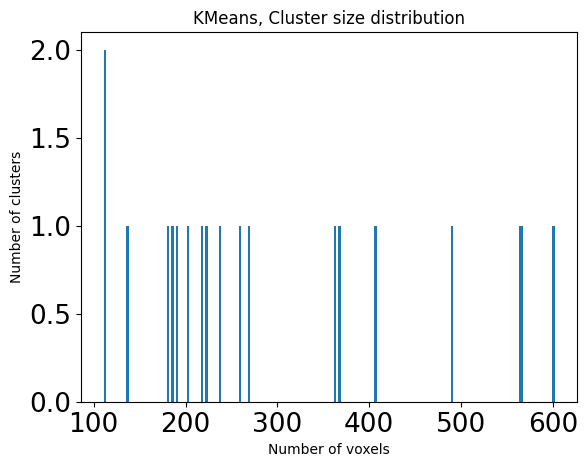

array([305, 222, 218, 407, 567, 187, 138, 181, 238, 111, 565, 362, 190,
       203, 368, 270, 602, 491, 112, 259])

In [49]:
unique_values, counts = np.unique(kmeans.labels_, return_counts=True)
counts

plt.hist(counts[1:], bins=200)
plt.xlabel("Number of voxels")
plt.ylabel("Number of clusters")
plt.title("KMeans, Cluster size distribution")
# plt.xscale('log')
# plt.semilogx()
plt.savefig(os.path.join(data_dir, 'kmeans_cluster_size_distribution.jpg'), dpi=300)
plt.show()
counts

/tmp/ipykernel_97121/3428395612.py:47: RuntimeWarning: Mean of empty slice
  lh_fsaverage = np.nanmean(lh_fsaverage, 0)
/tmp/ipykernel_97121/3428395612.py:48: RuntimeWarning: Mean of empty slice
  rh_fsaverage = np.nanmean(rh_fsaverage, 0)


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:13400): glibmm-WARNING **: 21:20:37.568: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.
(ld-linux-x86-64.so.2:13400): Pango-CRITICAL **: 21:20:37.569: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:13400): GLib-GObject-CRITICAL **: 21:20:37.569: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
(ld-linux-x86-64.so.2:13400): Pango-CRITICAL **: 21:20:37.578: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:13400): GLib-GObject-CRITICAL **: 21:20:37.578: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
** (ld-linux-x86-64.so.2:13400): WARNING **: 21:20:37.582: SPObject::updateDisplay(SPCtx *ctx, unsigned int flags) : throw in ((SPObjectClass *) G_OBJECT_GET_CLASS(this))->upda

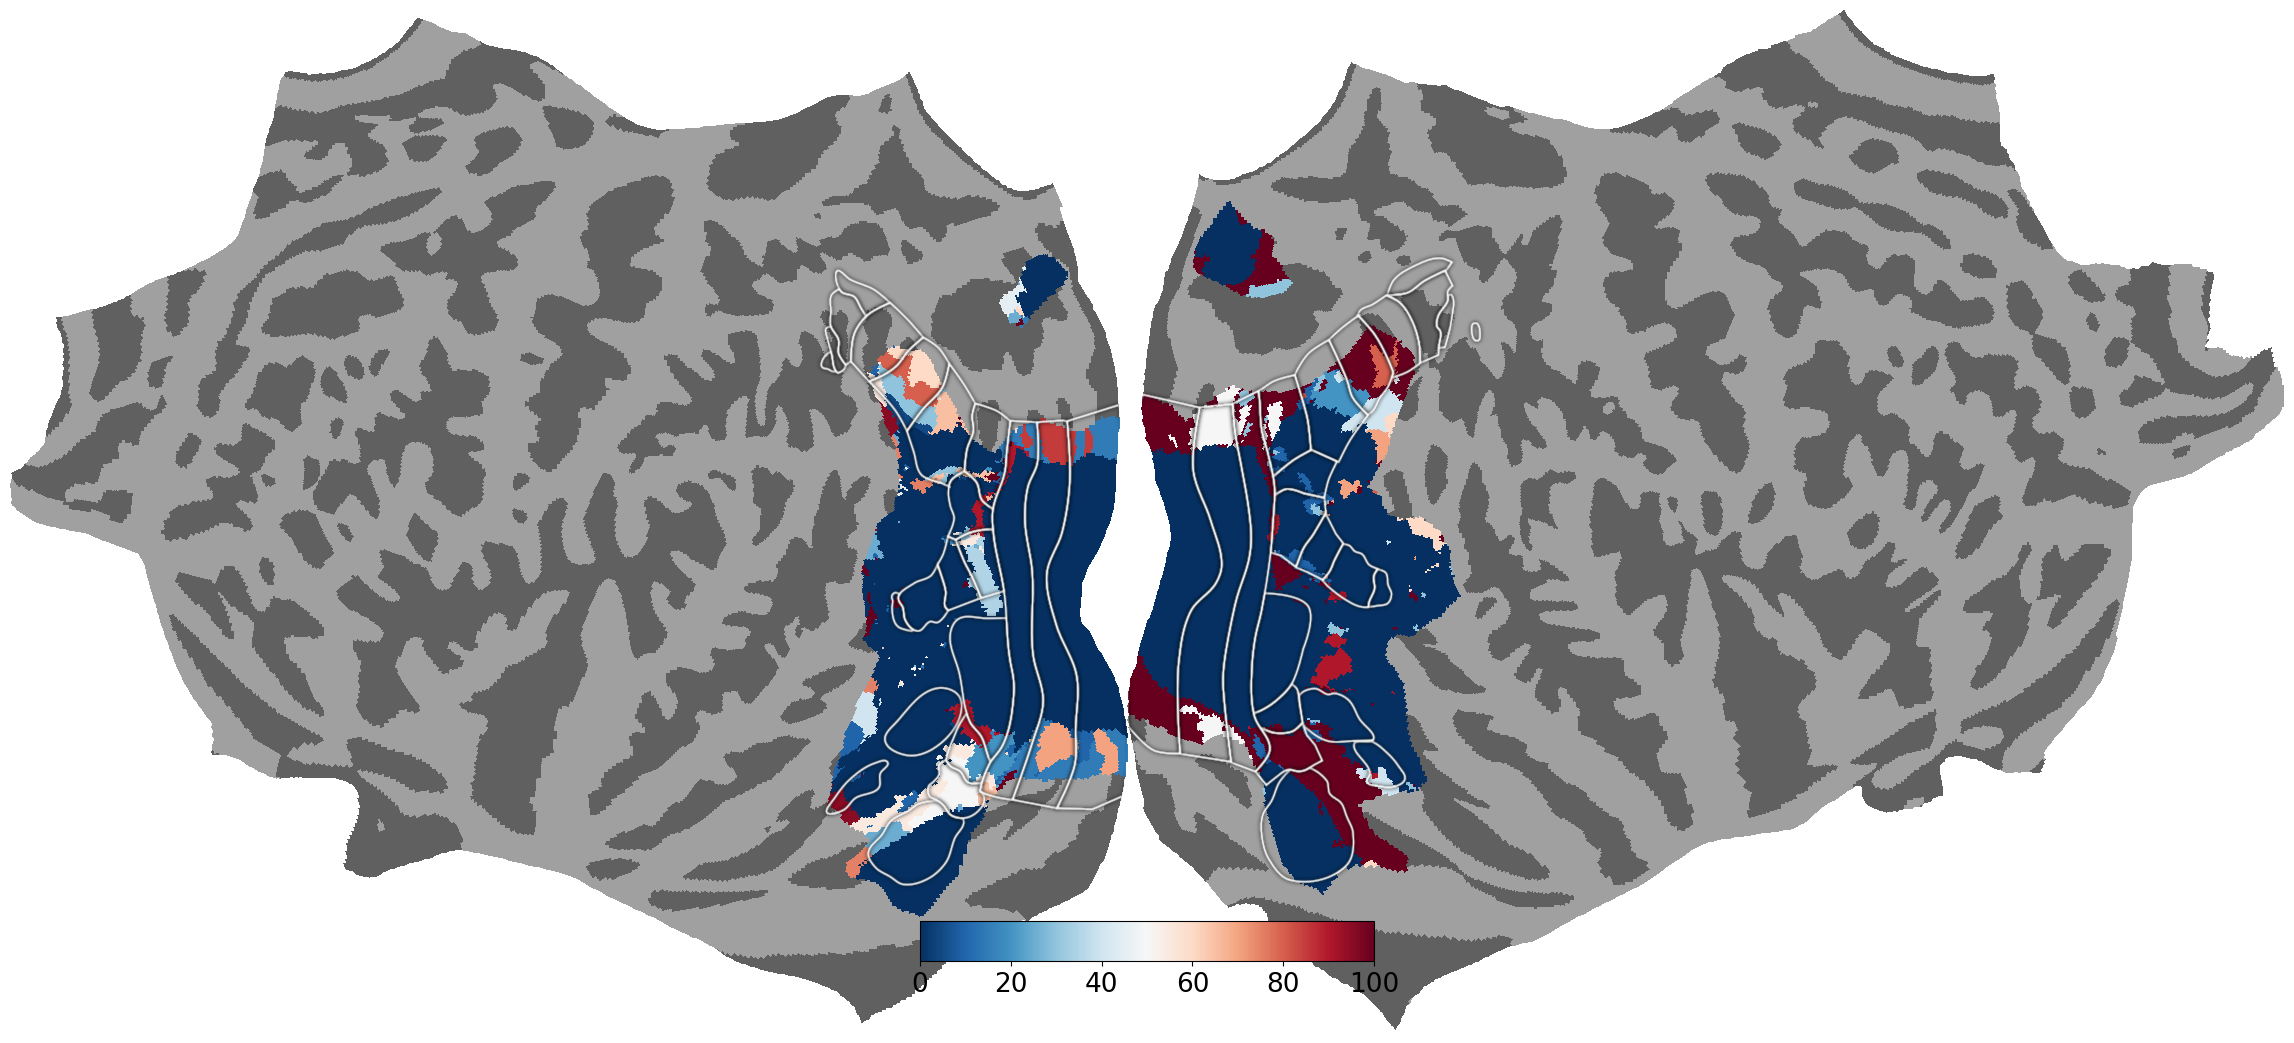

In [50]:
"""Plot data on a flattened brain surface using pycortex.

"""

import os
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import cortex
import cortex.polyutils

# =============================================================================
# Map the data to fsaverage space
# =============================================================================
# pycortex requires data in fsaverage space, so here you map the vertices from
# Challenge space into fsaverage space. The voxels not used in the Challenge
# are given NaN values, so that pycortex ignores them for the plotting.
# "ls_scores" and "rh_scores" are lists with 8 elements, one for each subject.
# These elements consist of vectors of length N, where N is the vertex amount
# for each subject and hemisphere, and each vector component consists of the
# prediction accuracy for that vertex.

#challenge_data_dir = '../algonauts_2023_challenge_data'
challenge_data_dir = '/engram/nklab/algonauts/algonauts_2023_challenge_data/'
lh_fsaverage = []
rh_fsaverage = []
subjects = [1]
for s, sub in enumerate(subjects):
    lh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'lh.all-vertices_fsaverage_space.npy')
    rh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'rh.all-vertices_fsaverage_space.npy')
    lh_fsaverage_all_vertices = np.load(lh_mask_dir)
    rh_fsaverage_all_vertices = np.load(rh_mask_dir)
    lh_fsavg = np.empty((len(lh_fsaverage_all_vertices)))
    lh_fsavg[:] = np.nan
    lh_fsavg[np.where(lh_fsaverage_all_vertices)[0]] = lh_challenge_rois_c #lh_scores[s]
    lh_fsaverage.append(copy(lh_fsavg))
    rh_fsavg = np.empty((len(rh_fsaverage_all_vertices)))
    rh_fsavg[:] = np.nan
    rh_fsavg[np.where(rh_fsaverage_all_vertices)[0]] = 2*rh_challenge_rois_c #rh_scores[s]
    rh_fsaverage.append(copy(rh_fsavg))
    
    break

# Average the scores across subjects
lh_fsaverage = np.nanmean(lh_fsaverage, 0)
rh_fsaverage = np.nanmean(rh_fsaverage, 0)


# =============================================================================
# Plot parameters for colorbar
# =============================================================================
plt.rc('xtick', labelsize=19)
plt.rc('ytick', labelsize=19)


# =============================================================================
# Plot the results on brain surfaces
# =============================================================================
subject = 'fsaverage'
data = np.append(lh_fsaverage, rh_fsaverage) * 5
vertex_data = cortex.Vertex(data, subject, cmap='RdBu_r', vmin=0, vmax=100)
cortex.quickshow(vertex_data, with_curvature=True)
plt.savefig('my_plot.png', dpi=300) 
plt.show()



In [19]:
np.max(lh_challenge_rois_c)

10

In [3]:
import numpy as np
import os
from cuml import KMeans, AgglomerativeClustering
import dask.array as da
from pathlib import Path


def kmeans(hemi, subj_num, method):
    file = f"{hemi}_betas_sub-0{subj_num}.npy"
    print("target:", file)

    nclusters = 1000
    print("nclusters:", nclusters)

    save_dir = Path("/engram/nklab/algonauts/ethan/parcelling/results/")
    print("save_dir:", save_dir)
    os.makedirs(save_dir / f"{nclusters}_{method}_5init_3000iter", exist_ok=True)

    data_dir = "/engram/nklab/datasets/natural_scene_dataset/model_training_datasets/neural_data"

    lh_betas = np.load(os.path.join(data_dir, file))

    lh_betas = lh_betas.T
    print("num voxels * num images:", lh_betas.shape)

    lh_betas = lh_betas.astype(np.float32)

    lh_betas = da.from_array(lh_betas, chunks=(8192, 30000))

    if method == "kmeans":
        algo = KMeans
    elif method == "ac":
        algo = AgglomerativeClustering

    algo1 = algo(
        n_clusters=nclusters, verbose=True, output_type="numpy", n_init=5, max_iter=3000
    )
    algo1.fit(lh_betas)

    # np.save(
    #     save_dir
    #     / f"{hemi}_{nclusters}_{method}_5init_3000iter"
    #     / f"algo1_labels_s0{subj_num}.npy",
    #     algo1.labels_,
    # )
    # np.save(
    #     save_dir
    #     / f"{hemi}_{nclusters}_{method}_5init_3000iter"
    #     / f"algo1_centers_s0{subj_num}.npy",
    #     algo1.cluster_centers_,
    # )

    algo2 = algo(
        n_clusters=2, verbose=True, output_type="numpy", n_init=5, max_iter=3000
    )
    algo2.fit(algo1.cluster_centers_)

    algo2_labels = algo2.labels_[algo1.labels_]

    labels = np.hstack((algo2_labels[:, None], algo1.labels_[:, None]))

    np.save(
        save_dir
        / f"{nclusters}_{method}_5init_3000iter"
        / f"{hemi}_labels_s{subj_num:02}.npy",
        labels,
    )


def main():
    for subj_num in range(1, 9):
        kmeans("lh", subj_num, "kmeans")
        kmeans("rh", subj_num, "kmeans")


if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'cuml'

torch.Size([3, 425, 425])


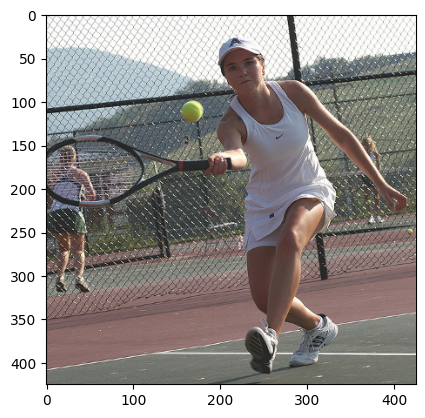

In [8]:
import torchvision.transforms as T
preprocess = T.Compose([
             T.ToTensor(),
             T.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])


train_img_dir  = os.path.join(args.data_dir, 'training_split', 'training_images')
image_path = train_img_dir + '/train-9039_nsd-66847.png'
image = Image.open(image_path)
plt.imshow(image)
img = preprocess(image)
print(img.shape)
patch_size = 14

size_im = (
    img.shape[0],
    int(np.ceil(img.shape[1] / patch_size) * patch_size),
    int(np.ceil(img.shape[2] / patch_size) * patch_size),
)
paded = torch.zeros(size_im)
paded[:, : img.shape[1], : img.shape[2]] = img
img = paded

imgs = img[None, :,:,:]

h = img.shape[-2] // patch_size
w = img.shape[-1] // patch_size

# train_loader, val_loader = fetch_nsd_dataloader(args, args.batch_size, train='train')
# test_loader = fetch_nsd_dataloader(args, args.batch_size, train='test')

In [48]:
'''
This model was trained using the following:

python main.py --readout_res 'faces' --save_model 1 --enc_output_layer 2
'''

readout_res = 'rois_all'
sub = '01'
enc_output_layer = 1

arch = 'dinov2_q_transformer'

dec_attn_weights_all = []

for run in range(4, 5):
    print(f'Run {run}')
    model_path = f'./results/nsd_test/{arch}/subj_{sub}/{readout_res}/enc_{enc_output_layer}/run_{run}/'
    model, args = load_model_path(model_path)

    enc_output, enc_attn_weights, dec_output, dec_attn_weights = \
      extract_transformer_features(model, images.to(device), enc_layers=0, dec_layers=1)


    dec_attn_weights_all.append(dec_attn_weights[0].reshape(-1,50,h, w).detach().cpu().numpy())

dec_attn_weights_all = np.array(dec_attn_weights_all)


Run 4


Using cache found in /home/ha2366/.cache/torch/hub/facebookresearch_dinov2_main


In [49]:
dec_attn_weights_all.shape

(1, 32, 50, 31, 31)

In [50]:
dec_attn_weights = dec_attn_weights_all.mean(0)

lh_challenge_rois_s.shape: torch.Size([24, 19004])
rh_challenge_rois_s.shape: torch.Size([24, 20544])
lh_challenge_rois_s.shape: torch.Size([25, 19004])
rh_challenge_rois_s.shape: torch.Size([25, 20544])


In [37]:
lh_challenge_rois_0.sum()

tensor(5350, device='cuda:0')

In [14]:
readout_res_all = ['visuals','bodies','faces','places','words','streams_inc']
roi_name_ind = readout_res_all.index(readout_res)

# Load the ROI classes mapping dictionaries
roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
    'mapping_floc-faces.npy', 'mapping_floc-places.npy',
    'mapping_floc-words.npy', 'mapping_streams.npy']
roi_name_maps = []
for r in roi_mapping_files:
    roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
        allow_pickle=True).item())

# Load the ROI brain surface maps
lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
    'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
    'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
    'lh.streams_challenge_space.npy']
rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
    'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
    'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
    'rh.streams_challenge_space.npy']
lh_challenge_rois = []
rh_challenge_rois = []
for r in range(len(lh_challenge_roi_files)):
    lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        lh_challenge_roi_files[r])))
    rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
        rh_challenge_roi_files[r])))
    
    
lh_rois = torch.tensor(lh_challenge_rois[args.rois_ind]).to(args.device)  # -1
rh_rois = torch.tensor(rh_challenge_rois[args.rois_ind]).to(args.device)  # -1

lh_challenge_rois_s = []
rh_challenge_rois_s = []
for i in range(args.roi_nums):
    lh_challenge_rois_s.append(torch.where(lh_rois == i, 1, 0))
    rh_challenge_rois_s.append(torch.where(rh_rois == i, 1, 0))

lh_challenge_rois_s = torch.vstack(lh_challenge_rois_s)
rh_challenge_rois_s = torch.vstack(rh_challenge_rois_s)

ValueError: 'rois_all' is not in list

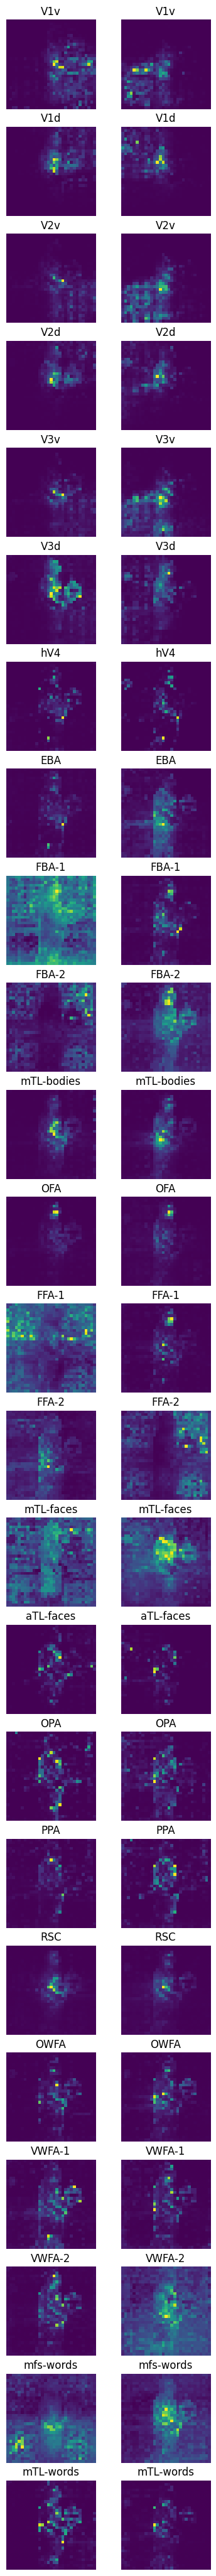

In [51]:
#plt.imshow(dec_attn_weights[0][1])
im_ind = 22

fig = plt.figure(figsize= (4.5, (2.29*(lh_challenge_rois_s.shape[0]-1))))
# and we add one plot per reference point
gs = fig.add_gridspec(lh_challenge_rois_s.shape[0], 2)
fig.subplots_adjust(wspace=0.1, hspace=0.2)

for i in range(2):
    for j in range(1,len(lh_roi_names)+1):
        ax = plt.subplot(gs[j-1, i])
        ax.imshow(dec_attn_weights[im_ind][(i*25) + j])
        plt.axis('off')
        if i == 0:
            ax.set_title(lh_roi_names[j-1])
        elif i == 1:
            ax.set_title(rh_roi_names[j-1])
#fig.savefig("../figures/faces.png", bbox_inches='tight', dpi=300)

In [29]:
images[0].shape

torch.Size([3, 434, 434])

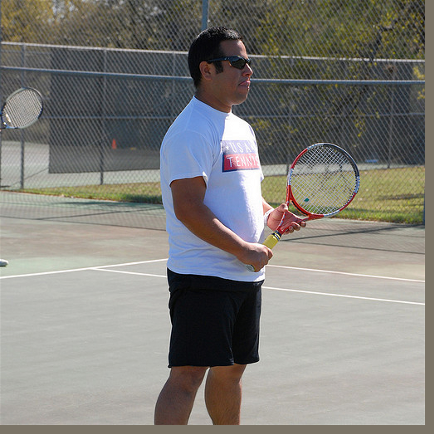

In [71]:
import torch
import torchvision.transforms as transforms

mean = [0.485, 0.456, 0.406]  # Mean used for normalization
std = [0.229, 0.224, 0.225]  # Standard deviation used for normalization

def denormalize(tensor, mean, std):
    """Denormalizes a tensor image."""
    # Create an inverse transform
    inv_normalize = transforms.Normalize(
        mean=[-m / s for m, s in zip(mean, std)],
        std=[1 / s for s in std]
    )

    # Apply the inverse transform
    return inv_normalize(tensor)


# Denormalize the tensor
denormalized_tensor = denormalize(images[im_ind], mean, std)
# Convert the tensor to a PIL Image
to_pil = transforms.ToPILImage()
image = to_pil(denormalized_tensor)
image

In [16]:
434/14


31.0

/tmp/ipykernel_28824/3049653592.py:47: RuntimeWarning: Mean of empty slice
  lh_fsaverage = np.nanmean(lh_fsaverage, 0)
/tmp/ipykernel_28824/3049653592.py:48: RuntimeWarning: Mean of empty slice
  rh_fsaverage = np.nanmean(rh_fsaverage, 0)


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:47662): glibmm-WARNING **: 00:14:10.385: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.
(ld-linux-x86-64.so.2:47662): Pango-CRITICAL **: 00:14:10.385: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:47662): GLib-GObject-CRITICAL **: 00:14:10.385: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
(ld-linux-x86-64.so.2:47662): Pango-CRITICAL **: 00:14:10.393: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:47662): GLib-GObject-CRITICAL **: 00:14:10.394: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
** (ld-linux-x86-64.so.2:47662): WARNING **: 00:14:10.397: SPObject::updateDisplay(SPCtx *ctx, unsigned int flags) : throw in ((SPObjectClass *) G_OBJECT_GET_CLASS(this))->upda

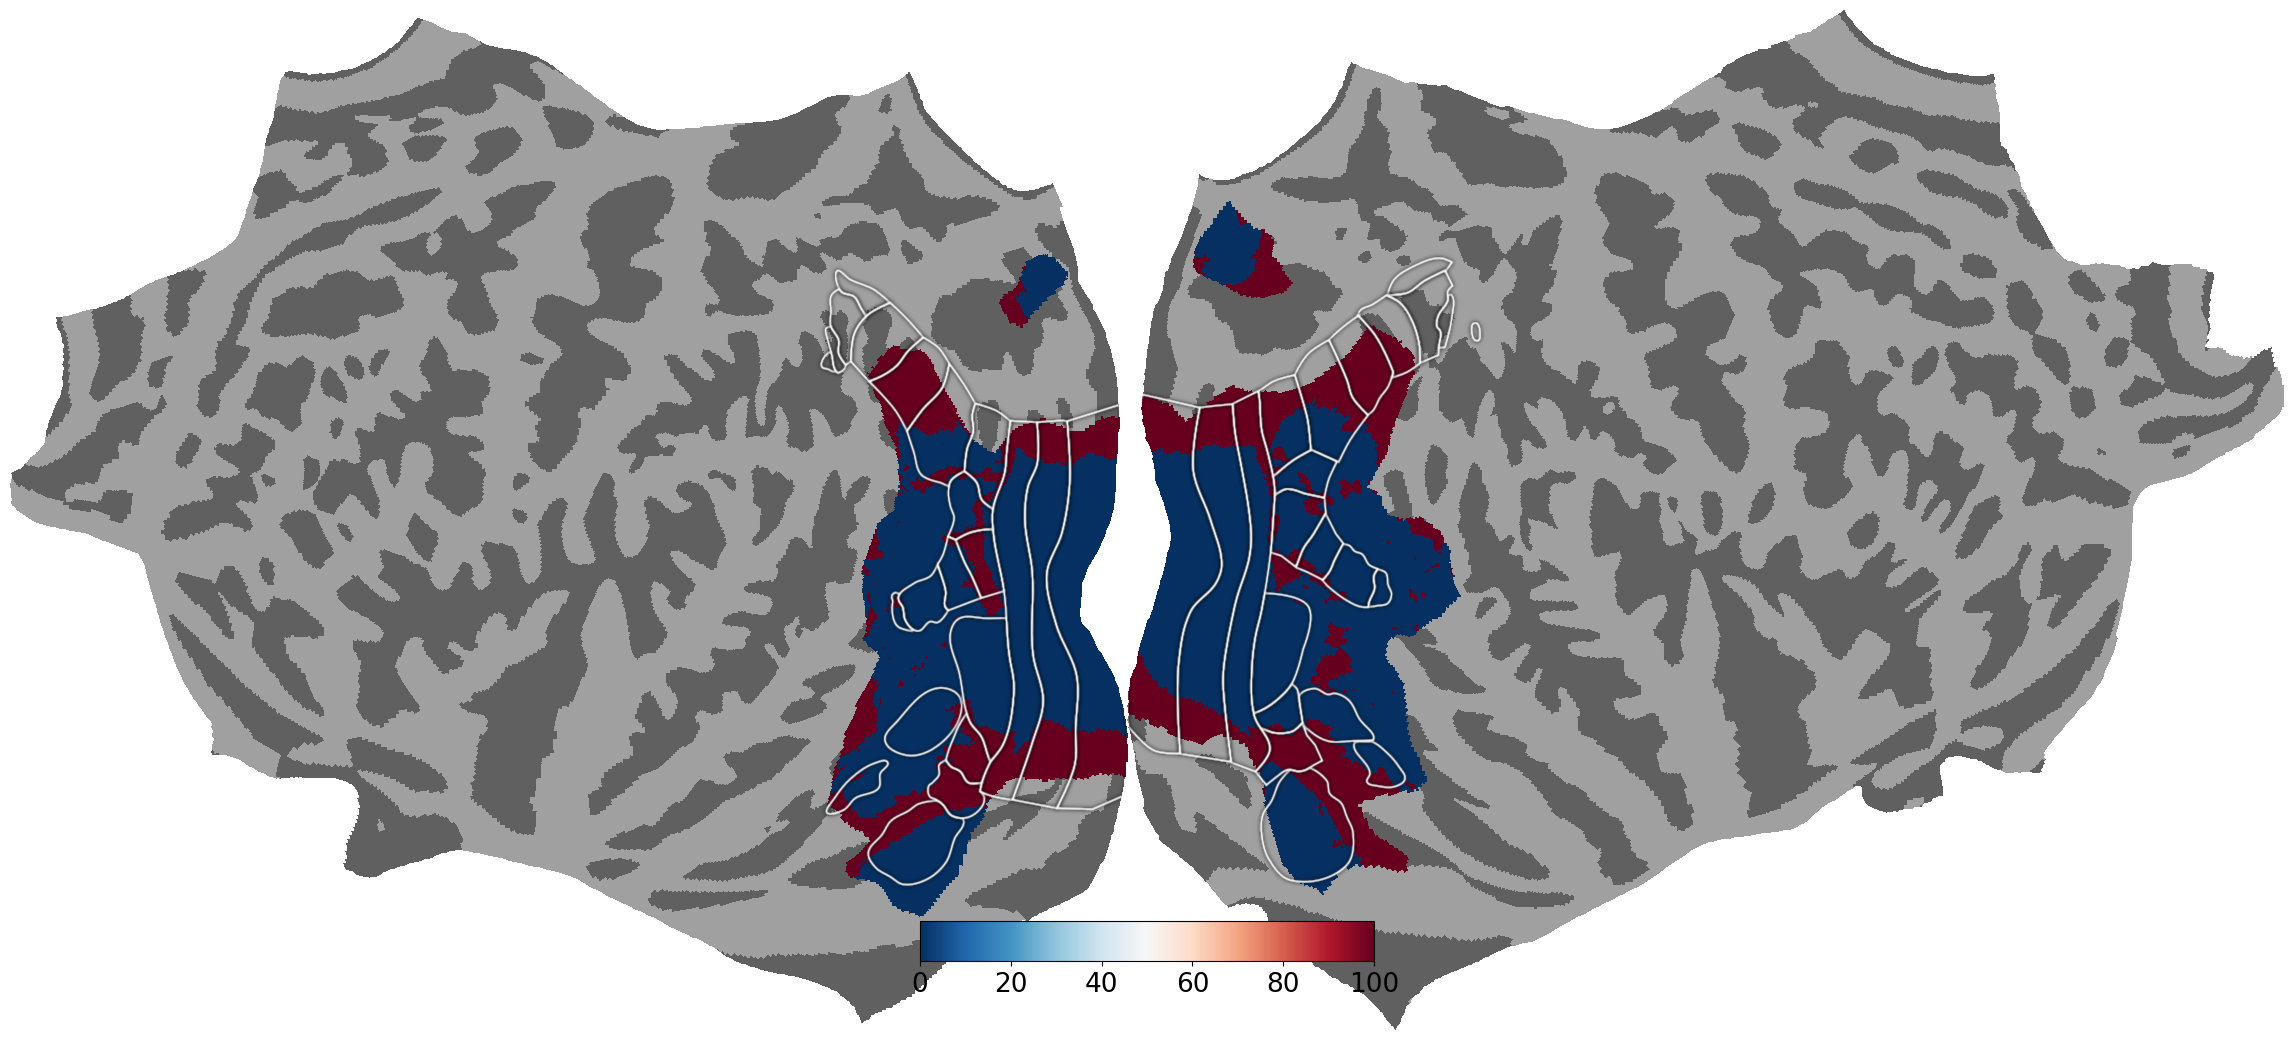